<a href="https://colab.research.google.com/github/DietzscheNostoevsky/Learning_Pytorch/blob/main/08_Pytorch_Paper_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Paper Replication

# 0. Getting setup 





We'll import the Python scripts (such as `data_setup.py` and `engine.py`)  created in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).

To do so, we'll download [`going_modular`](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular) directory from the `pytorch-deep-learning` repository (if we don't already have it).

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available. 

`torchinfo` will help later on to give us a visual representation of our model.

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3768, done.
remote: Counting objects: 100% (390/390), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 3768 (delta 209), reused 321 (delta 168), pack-reused 3378
Receiving objects: 100% (3768/3768), 648.94 MiB | 36.09 MiB/s, done.
Resolving deltas: 100% (2165/2165), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Get Data



download the pizza, steak and sushi image dataset we've been using.

To do so we can use the `download_data()` function from `helper_functions.py` that we created in [07. PyTorch Experiment Tracking section 1](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#1-get-data).

We'll `source` to the raw GitHub link of the [`pizza_steak_sushi.zip` data](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip) and the `destination` to `pizza_steak_sushi`.

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

setup the training and test directories.

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Creating Datasets and Dataloaders

## Creating transforms 

In [ ]:
# Paper, table 3 says trainingig resolution = 224

IMG_SIZE = 224

# Manual transform pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

## Turning images into Dataloaders



The ViT paper states the use of a batch size of 4096 which is 128x the size of the batch size we've been using (32).

However, we're going to stick with a batch size of 32.



Because some hardware (including the free tier of Google Colab) may not be able to handle a batch size of 4096.


> **Note:** We're using the `pin_memory=True` parameter in the `create_dataloaders()` function to speed up computation. `pin_memory=True` avoids unnecessary copying of memory between the CPU and GPU memory by "pinning" examples that have been seen before. Though the benefits of this will likely be seen with larger dataset sizes (our FoodVision Mini dataset is quite small). However, setting `pin_memory=True` doesn't *always* improve performance (this is another one of those we're scenarios in machine learning where some things work sometimes and don't other times), so best to *experiment, experiment, experiment*. See the PyTorch [`torch.utils.data.DataLoader` documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) or [Making Deep Learning Go Brrrr from First Principles](https://horace.io/brrr_intro.html) by Horace He for more. 

In [ ]:
BATCH_SIZE = 32

# Creating data loaders 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f69ad76edd0>,
 ['pizza', 'steak', 'sushi'])

## Visualizing single images

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

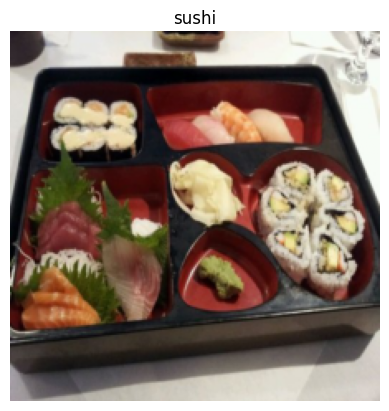

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

#

## 3. Replicating the ViT paper: an overview



Before we write anymore code, let's discuss what we're doing.

We'd like to replicate the ViT paper for our own problem, FoodVision Mini.

So our **model inputs** are: images of pizza, steak and sushi.

And our ideal **model outputs** are: predicted labels of pizza, steak or sushi.

No different to what we've been doing throughout the previous sections.

The question is: how do we go from our inputs to the desired outputs?

### 3.1 Inputs and outputs, layers and blocks



ViT is a deep learning neural network architecture.

And any neural network architecture is generally comprised of **layers**.

And a collection of layers is often referred to as a **block**.

And stacking many blocks together is what gives us the whole architecture.

A **layer** takes an input (say an image tensor), performs some kind of function on it (for example what's in the layer's `forward()` method) and then returns an output.

So if a **single layer** takes an input and gives an output, then a collection of layers or a **block** also takes an input and gives an output.

Let's make this concrete:
* **Layer** - takes an input, performs a function on it, returns an output.
* **Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* **Architecture (or model)** - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

This ideology is what we're going to be using to replicate the ViT paper.

We're going to take it layer by layer, block by block, function by function putting the pieces of the puzzle together like Lego to get our desired overall architecture.

The reason we do this is because looking at a whole research paper can be intimidating.

So for a better understanding, we'll break it down, starting with the inputs and outputs of single layer and working up to the inputs and outputs of the whole model.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-intputs-outputs-layers-and-blocks.png" alt="inputs and outputs, layers and blocks of a model" width=900/>

*A modern deep learning architecture is usually collection of layers and blocks. Where layers take an input (data as a numerical representation) and manipulate it using some kind of function (for example, the self-attention formula pictured above, however, this function could be almost anything) and then output it. Blocks are generally stacks of layers on top of each other doing a similar thing to a single layer but multiple times.* 

### 3.2 Getting specific: What's ViT made of?



There are many little details about the ViT model sprinkled throughout the paper.

Finding them all is like one big treasure hunt!

Remember, a research paper is often months of work compressed into a few pages so it's understandable for it to take of practice to replicate.

However, the main three resources we'll be looking at for the architecture design are:
1. **Figure 1** - This gives an overview of the model in a graphical sense, you could *almost* recreate the architecture with this figure alone.
2. **Four equations in section 3.1** - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
3. **Table 1** - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.

#### 3.2.1 Exploring Figure 1



Let's start by going through Figure 1 of the ViT Paper.

The main things we'll be paying attention to are:
1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.* 

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and add a position number what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1). 
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

You might notice that many of the pieces of the ViT architecture can be created with existing PyTorch layers.

This is because of how PyTorch is designed, it's one of the main purposes of PyTorch to create reusable neural network layers for both researchers and machine learning practitioners.

> **Question:** Why not code everything from scratch?
>
> You could definitely do that by reproducing all of the math equations from the paper with custom PyTorch layers and that would certainly be an educative exercise, however, using pre-existing PyTorch layers is usually favoured as pre-existing layers have often been extensively tested and performance checked to make sure they run correctly and fast. 

> **Note:** We're going to focused on write PyTorch code to create these layers, for the background on what each of these layers does, I'd suggest reading the ViT Paper in full or reading the linked resources for each layer.

Let's take Figure 1 and adapt it to our FoodVision Mini problem of classifying images of food into pizza, steak or sushi.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>

*Figure 1 from the ViT Paper adapted for use with FoodVision Mini. An image of food goes in (pizza), the image gets turned into patches and then projected to an embedding. The embedding then travels through the various layers and blocks and (hopefully) the class "pizza" is returned.*

#### 3.2.2 Exploring the Four Equations



The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

*These four equations represent the math behind the four major parts of the ViT architecture.*

Section 3.1 describes each of these (some of the text has been omitted for brevity, bolded text is mine):

| **Equation number** | **Description from ViT paper section 3.1** | 
| ----- | ----- | 
| 1 | ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings**... **Position embeddings** are added to the patch embeddings to retain positional information. We use standard **learnable 1D position embeddings**...|
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we **prepend a learnable embedding to the sequence of embedded patches** $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)... |

Let's map these descriptions to the ViT architecture in Figure 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>

*Connecting Figure 1 from the ViT paper to the four equations from section 3.1 describing the math behind each of the layers/blocks.*

There's a lot happening in the image above but following the coloured lines and arrows reveals the main concepts of the ViT architecture.

How about we break down each equation further (it will be our goal to recreate these with code)?

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer *prime*" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

#### 3.2.3 Equation 1 overview



$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```

Where each of the elements in the vector is learnable (their `requires_grad=True`).

#### 3.2.4 Equation 2 overview



$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a [skip/residual connection](https://paperswithcode.com/method/residual-connection).

We'll call this layer the "MSA block".

In pseudocode, this might look like: 

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

##### Residual/Skip Connection



**From ChatGPT**

A residual connection, also known as a skip connection, is a technique used in deep neural networks to mitigate the vanishing gradient problem and facilitate the training of deeper architectures. It involves adding the original input of a layer (or a transformed version of it) to the output of that layer.

In a typical neural network layer, the input is transformed through a series of operations, such as convolutions, linear transformations, and activation functions. The output of these operations is then passed to the next layer as input. In a residual connection, the original input of a layer is added to its output before passing it to the next layer.

The purpose of a residual connection is to provide a shortcut path for the gradient during backpropagation. In deep networks, as the gradient flows backward through many layers, it can gradually diminish or even vanish, making it difficult for earlier layers to update their weights effectively. By adding the input to the output, the residual connection allows the gradient to bypass a portion of the layer's transformations, preserving more information about the original input. This helps to alleviate the vanishing gradient problem and enables better gradient flow throughout the network.

The addition operation in a residual connection is performed element-wise, meaning that the dimensions of the input and output must match. In some cases, a linear projection is applied to the input before adding it to the output to ensure compatibility. This projection can be implemented using a 1x1 convolution or a fully connected layer.

Residual connections have been widely adopted in deep neural network architectures, including the popular ResNet (Residual Network) models. They have shown to be effective in improving training convergence, enabling the training of very deep networks, and achieving state-of-the-art performance on various tasks, such as image classification, object detection, and machine translation.

#### 3.2.5 Equation 3 overview



$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like: 

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.6 Equation 4 overview



$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of `x_output_MLP_block`:

```python
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

Of course there are some simplifications above but we'll take care of those when we start to write PyTorch code for each section.

> **Note:** The above section covers alot of information. But don't forget if something doesn't make sense, you can always research it further. By asking questions like "what is a residual connection?".

#### 3.2.7 Exploring Table 1



The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>
<br>

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:
* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture. 

### 3.3 Paper Replication Workflow



When I start working on replicating a paper, I go through the following steps:

1. Read the whole paper end-to-end once (to get an idea of the main concepts).
2. Go back through each section and see how they line up with each other and start thinking about how they might be turned into code (just like above).
3. Repeat step 2 until I've got a fairly good outline.
4. Use [mathpix.com](https://mathpix.com/) (a very handy tool) to turn any sections of the paper into markdown/LaTeX to put into notebooks.
5. Replicate the simplest version of the model possible.
6. If I get stuck, look up other examples.

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-mathpix-demo.gif" width=900 alt="using mathpix.com to turn text from a machine learning research paper (PDF) into editable LaTeX"/>

*Turning the four equations from the ViT paper into editable LaTeX/markdown using [mathpix.com](https://mathpix.com/).* 

We've already gone through the first few steps above (and if you haven't read the full paper yet, I'd encourage you to give it a go) but what we'll be focusing on next is step 5: replicating the simplest version fo the model possible.

This is why we're starting with ViT-Base.

Replicating the smallest version of the architecture possible, get it working and then we can scale up if we wanted to.

> **Note:** If you've never read a research paper before, many of the above steps can be intimidating. But don't worry, like anything, your skills at reading *and* replicating papers will improve with practice. Don't forget, a research paper is often *months* of work by many people compressed into a few pages. So trying to replicate it on your own is no small feat. 

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding 



I remember one of my machine learning engineer friends used to say "it's all about the embedding."

As in, if you can represent your data in a good, learnable way (as **embeddings are learnable representations**), chances are, a learning algorithm will be able to perform well on them.

With that being said, let's start by creating the class, position and patch embeddings for the ViT architecture.

We'll start with the **patch embedding**.

This means we'll be turning our input images in a sequence of patches and then embedding those patches.

Recall that an **embedding** is a learnable representation of some form and is often a vector. 

The term learnable is important because this means the numerical representation of an input image (that the model sees) can be improved over time.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):

> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

And size we're dealing with image shapes, let's keep in mind the line from Table 3 of the ViT paper: 

> Training resolution is **224**.

Let's break down the text above.

* $D$ is the size of the **patch embeddings**, different values for $D$ for various sized ViT models can be found in Table 1.
* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (**patch size**).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png" width=900 alt="mapping the vit architecture diagram positional and patch embeddings portion to the relative mathematical equation describing what's going on"/>

*Mapping the patch and position embedding portion of the ViT architecture from Figure 1 to Equation 1. The opening paragraph of section 3.1 describes the different input and output shapes of the patch embedding layer.*

### 4.1 Calculating patch embedding input and output shapes by hand



How about we start by calculating these input and output shape values by hand?

To do so, let's create some variables to mimic each of the terms (such as $H$, $W$ etc) above.

We'll use a patch size ($P$) of 16 since it's the best performing version of ViT-Base uses (see column "ViT-B/16" of Table 5 in the ViT paper for more).

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


We've got the number of patches, how about we create the image output size as well?

Better yet, let's replicate the input and output shapes of the patch embedding layer.

Recall:

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [ ]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


Input and output shapes acquired!

### 4.2 Turning a single image into patches

Now we know the ideal input and output shapes for our **patch embedding** layer, let's move towards making it.

What we're doing is breaking down the overall architecture into smaller pieces, focusing on the inputs and outputs of individual layers.

So how do we create the patch embedding layer?

We'll get to that shortly, first, let's *visualize, visualize, visualize!* what it looks like to turn an image into patches.

Let's start with our single image.

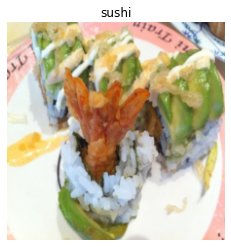

In [ ]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

We want to turn this image into patches of itself inline with Figure 1 of the ViT paper.

How about we start by just visualizing the top row of patched pixels?

We can do this by indexing on the different image dimensions.

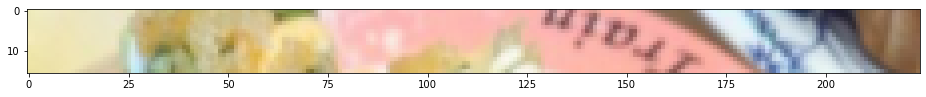

In [ ]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Now we've got the top row, let's turn it into patches.

We can do this by iterating through the number of patches there'd be in the top row. 

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


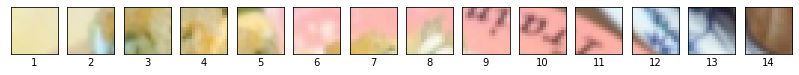

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Those are some nice looking patches!

How about we do it for the whole image?

This time we'll iterate through the indexs for height and width and plot each patch as it's own subplot.

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


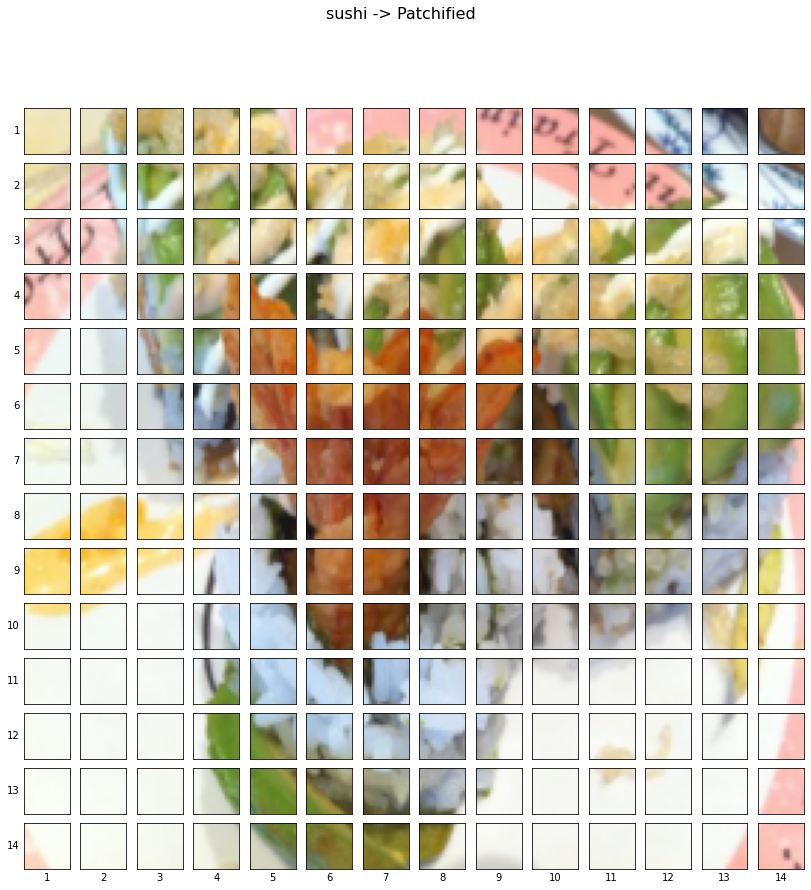

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

Image patchified!

Woah, that looks cool.

Now how do we turn each of these patches into an embedding and convert them into a sequence?

Hint: we can use PyTorch layers. Can you guess which?

### 4.3 Creating image patches with `torch.nn.Conv2d()`

We've seen what an image looks like when it gets turned into patches, now let's start moving towards replicating the patch embedding layers with PyTorch.

To visualize our single image we wrote code to loop through the different height and width dimensions of a single image and plot individual patches.

This operation is very similar to the convolutional operation we saw in [03. PyTorch Computer Vision section 7.1: Stepping through `nn.Conv2d()`](https://www.learnpytorch.io/03_pytorch_computer_vision/#71-stepping-through-nnconv2d).

In fact, the authors of the ViT paper mention in section 3.1 that the patch embedding is achievable with a convolutional neural network (CNN):  

> **Hybrid Architecture.** As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection $\mathbf{E}$ (Eq. 1) is applied to patches extracted from a **CNN feature map**. As a special case, the patches can have spatial size $1 \times 1$, which means that the **input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension**. The classification input embedding and position embeddings are added as described above.

The "**feature map**" they're refering to are the weights/activations produced by a convolutional layer passing over a given image.

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-patch-embedding-animation.gif" width=900 alt="example of creating a patch embedding by passing a convolutional layer over a single image"/>

*By setting the `kernel_size` and `stride` parameters of a [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer equal to the `patch_size`, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.* 

Remember our ideal input and output shapes for the patch embedding layer?

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Or for an image size of 224 and patch size of 16:

* **Input (2D image):** (224, 224, 3) -> (height, width, color channels)
* **Output (flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension)

We can recreate these with:
* [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for turning our image into patches of CNN feature maps.
* [`torch.nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) for flattening the spatial dimensions of the feature map.

Let's start with the `torch.nn.Conv2d()` layer.

We can replicate the creation of patches by setting the `kernel_size` and `stride` equal to `patch_size`.

This means each convolutional kernel will be of size `(patch_size x patch_size)` or if `patch_size=16`, `(16 x 16)` (the equivalent of one whole patch).

And each step or `stride` of the convolutional kernel will be `patch_size` pixels long or `16` pixels long (equivalent of stepping to the next patch).

We'll set `in_channels=3` for the number of color channels in our image and we'll set `out_channels=768`, the same as the $D$ value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a learnable vector of size 768).

In [ ]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

Now we've got a convoluational layer, let's see what happens when we pass a single image through it.

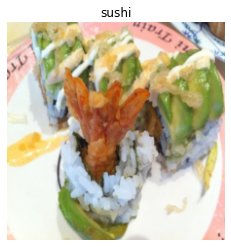

In [ ]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Passing our image through the convolutional layer turns it into a series of 768 (this is the embedding size or $D$) feature/activation maps.

So its output shape can be read as:
    
```python
torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Let's visualize five random feature maps and see what they look like.

Showing random convolutional feature maps from indexes: [571, 727, 734, 380, 90]


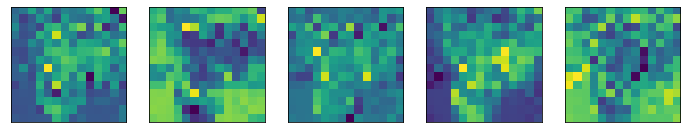

In [ ]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

Notice how the feature maps all kind of represent the original image, after visualizing a few more you can start to see the different major outlines and some major features.

The important thing to note is that these features may change over time as the neural network learns.

And because of these, these feature maps can be considered a **learnable embedding** of our image.

Let's check one out in numerical form.

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.4732,  0.3567,  0.3377,  0.3736,  0.3208,  0.3913,  0.3464,
            0.3702,  0.2541,  0.3594,  0.1984,  0.3982,  0.3741,  0.1251],
          [ 0.4178,  0.4771,  0.3374,  0.3353,  0.3159,  0.4008,  0.3448,
            0.3345,  0.5850,  0.4115,  0.2969,  0.2751,  0.6150,  0.4188],
          [ 0.3209,  0.3776,  0.4970,  0.4272,  0.3301,  0.4787,  0.2754,
            0.3726,  0.3298,  0.4631,  0.3087,  0.4915,  0.4129,  0.4592],
          [ 0.4540,  0.4930,  0.5570,  0.2660,  0.2150,  0.2044,  0.2766,
            0.2076,  0.3278,  0.3727,  0.2637,  0.2493,  0.2782,  0.3664],
          [ 0.4920,  0.5671,  0.3298,  0.2992,  0.1437,  0.1701,  0.1554,
            0.1375,  0.1377,  0.3141,  0.2694,  0.2771,  0.2412,  0.3700],
          [ 0.5783,  0.5790,  0.4229,  0.5032,  0.1216,  0.1000,  0.0356,
            0.1258, -0.0023,  0.1640,  0.2809,  0.2418,  0.2606,  0.3787],
          [ 0.5334,  0.5645,  0.4781,  0.3307,  0.2391,  0.0461,  0.0095,
            0.0542,  0.1012,  0.

The `grad_fn` output of the `single_feature_map` and the `requires_grad=True` attribute means PyTorch is tracking the gradients of this feature map and it will be updated by gradient descent during training. 

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

We've turned our image into patch embeddings but they're still in 2D format.

How do we get them into the desired output shape of the patch embedding layer of the ViT model?

* **Desried output (1D sequence of flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension) -> ${N \times\left(P^{2} \cdot C\right)}$

Let's check the current shape.

In [ ]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


Well we've got the 768 part ( $(P^{2} \cdot C)$ ) but we still need the number of patches ($N$).

Reading back through section 3.1 of the ViT paper it says (bold mine):

> As a special case, the patches can have spatial size $1 \times 1$, which means that the **input sequence is obtained by simply *flattening* the spatial dimensions of the feature map and projecting to the Transformer dimension**.

Flattening the spatial dimensions of the feature map hey?

What layer do we have in PyTorch that can flatten?

How about [`torch.nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html )?

But we don't want to flatten the whole tensor, we only want to flatten the "spatial dimensions of the feature map".

Which in our case is the `feature_map_height` and `feature_map_width` dimensions of `image_out_of_conv`.

So how about we create a `torch.nn.Flatten()` layer to only flatten those dimensions, we can use the `start_dim` and `end_dim` parameters to set that up?

In [ ]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Nice! Now let's put it all together!

We'll:
1. Take a single image.
2. Put in through the convolutional layer (`conv2d`) to turn the image into 2D feature maps (patch embeddings).
3. Flatten the 2D feature map into a single sequence.

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


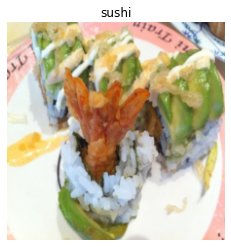

In [ ]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Woohoo! It looks like our `image_out_of_conv_flattened` shape is very close to our desired output shape: 
    
* **Desried output (flattened 2D patches):** (196, 768) -> ${N \times\left(P^{2} \cdot C\right)}$
* **Current shape:** (1, 768, 196)

The only difference is our current shape has a batch size and the dimensions are in a different order to the desired output.

How could we fix this?

Well, how about we rearrange the dimensions?

We can do so with `torch.Tensor.permute()` just like we do when rearranging image tensors to plot them with matplotlib.

Let's try.

In [ ]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


Yes!!!

We've now matched the desired input and output shapes for the patch embedding layer of the ViT architecture using a couple of PyTorch layers.

How about we visualize one of the flattened feature maps?

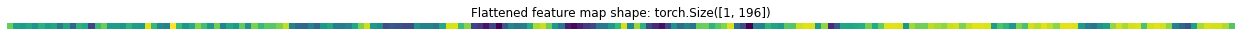

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

Hmm, the flattened feature map doesn't look like much visually, but that's not what we're concerned about, this is what will be the output of the patching embedding layer and the input to the rest of the ViT architecture.

> **Note:** The [original Transformer architecture](https://arxiv.org/abs/1706.03762) was designed to work with text. The Vision Transformer architecture (ViT) had the goal of using the original Transformer for images. This is why the input to the ViT architecture is processed in the way it is. We're essentially taking a 2D image and formatting it so it appears as a 1D sequence of text. 

How about we view the flattened feature map in tensor form?

In [ ]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.4732,  0.3567,  0.3377,  0.3736,  0.3208,  0.3913,  0.3464,  0.3702,
           0.2541,  0.3594,  0.1984,  0.3982,  0.3741,  0.1251,  0.4178,  0.4771,
           0.3374,  0.3353,  0.3159,  0.4008,  0.3448,  0.3345,  0.5850,  0.4115,
           0.2969,  0.2751,  0.6150,  0.4188,  0.3209,  0.3776,  0.4970,  0.4272,
           0.3301,  0.4787,  0.2754,  0.3726,  0.3298,  0.4631,  0.3087,  0.4915,
           0.4129,  0.4592,  0.4540,  0.4930,  0.5570,  0.2660,  0.2150,  0.2044,
           0.2766,  0.2076,  0.3278,  0.3727,  0.2637,  0.2493,  0.2782,  0.3664,
           0.4920,  0.5671,  0.3298,  0.2992,  0.1437,  0.1701,  0.1554,  0.1375,
           0.1377,  0.3141,  0.2694,  0.2771,  0.2412,  0.3700,  0.5783,  0.5790,
           0.4229,  0.5032,  0.1216,  0.1000,  0.0356,  0.1258, -0.0023,  0.1640,
           0.2809,  0.2418,  0.2606,  0.3787,  0.5334,  0.5645,  0.4781,  0.3307,
           0.2391,  0.0461,  0.0095,  0.0542,  0.1012,  0.1331,  0.2446,  0.2526,
           0.332

Beautiful!

We've turned our single 2D image into a 1D learnable embedding vector (or "Linear Projection of Flattned Patches" in Figure 1 of the ViT paper).

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

Time to put everything we've done for creating the patch embedding into a single PyTorch layer.

We can do so by subclassing `nn.Module` and creating a small PyTorch "model" to do all of the steps above.

Specifically we'll:
1. Create a class called `PatchEmbedding` which subclasses `nn.Module` (so it can be used a PyTorch layer).
2. Initialize the class with the parameters `in_channels=3`, `patch_size=16` (for ViT-Base) and `embedding_dim=768` (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using `nn.Conv2d()` (just like in 4.3 above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above). 
5. Define a `forward()` method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture (${N \times\left(P^{2} \cdot C\right)}$).

Let's do it!

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

`PatchEmbedding` layer created!

Let's try it out on a single image.

In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


Beautiful!

The output shape matches the ideal input and output shapes we'd like to see from the patch embedding layer:

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Where:
* $(H, W)$ is the resolution of the original image.
* $C$ is the number of channels.
* $(P, P)$ is the resolution of each image patch (**patch size**).
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.
    
We've now replicated the patch embedding for equation 1 but not the class token/position embedding.

We'll get to these later on.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-replicating-the-patch-embedding-layer.png" width=900 alt="replicating the vision transformer architecture patch embedding layer"/>

*Our `PatchEmbedding` class (right) replicates the patch embedding of the ViT architecture from Figure 1 and Equation 1 from the ViT paper (left). However, the learnable class embedding and position embeddings haven't been created yet. These will come soon.*

Let's now get a summary of our `PatchEmbedding` layer.

In [ ]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
# summary(PatchEmbedding(), 
#         input_size=random_input_image, # try swapping this for "random_input_image_error" 
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-summary-output-patchembedding.png" alt="summary output of patchembedding layer for vision transformer with input and output shapes" width=900/>

### 4.6 Creating the class token embedding

Okay we've made the image patch embedding, time to get to work on the class token embedding.

Or $\mathbf{x}_\text {class }$ from equation 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-class-token.png" width=900 alt="class token embedding highlight from the vision transformer paper figure 1 and section 3.1"/>

*Left: Figure 1 from the ViT paper with the "classification token" or `[class]` embedding token we're going to recreate highlighted. Right: Equation 1 and section 3.1 of the ViT paper that relate to the learnable class embedding token.*

Reading the second paragraph of section 3.1 from the ViT paper, we see the following description: 

> Similar to BERT's `[ class ]` token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). 

> **Note:** [BERT](https://arxiv.org/abs/1810.04805) (Bidirectional Encoder Representations from Transformers) is one of the original machine learning research papers to use the Transformer architecture to achieve outstanding results on natural language processing (NLP) tasks and is where the idea of having a `[ class ]` token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.

So we need to "preprend a learnable embedding to the sequence of embedded patches".

Let's start by viewing our sequence of embedded patches tensor (created in section 4.5) and its shape.

In [ ]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.9145,  0.2454, -0.2292,  ...,  0.6768, -0.4515,  0.3496],
         [-0.7427,  0.1955, -0.3570,  ...,  0.5823, -0.3458,  0.3261],
         [-0.7589,  0.2633, -0.1695,  ...,  0.5897, -0.3980,  0.0761],
         ...,
         [-1.0072,  0.2795, -0.2804,  ...,  0.7624, -0.4584,  0.3581],
         [-0.9839,  0.1652, -0.1576,  ...,  0.7489, -0.5478,  0.3486],
         [-0.9260,  0.1383, -0.1157,  ...,  0.5847, -0.4717,  0.3112]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


To "prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in the shape of the `embedding_dimension` ($D$) and then add it to the `number_of_patches` dimension. 

Or in pseudocode:

```python
patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
```

Notice the concatenation (`torch.cat()`) happens on `dim=1` (the `number_of_patches` dimension).

Let's create a learnable embedding for the class token.

To do so, we'll get the batch size and embedding dimension shape and then we'll create a `torch.ones()` tensor in the shape `[batch_size, 1, embedding_dimension]`.

And we'll make the tensor learnable by passing it to `nn.Parameter()` with `requires_grad=True`.

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


> **Note:** Here we're only creating the class token embedding as [`torch.ones()`](https://pytorch.org/docs/stable/generated/torch.ones.html) for demonstration purposes, in reality, you'd likely create the class token embedding with [`torch.randn()`](https://pytorch.org/docs/stable/generated/torch.randn.html) (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time). 

See how the `number_of_tokens` dimension of `class_token` is `1` since we only want to prepend one class token value to the start of the patch embedding sequence.

Now we've got the class token embedding, let's prepend it to our sequence of image patches, `patch_embedded_image`.

We can do so using [`torch.cat()`](https://pytorch.org/docs/stable/generated/torch.cat.html) and set `dim=1` (so `class_token`'s `number_of_tokens` dimension is preprended to `patch_embedded_image`'s `number_of_patches` dimension).

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9145,  0.2454, -0.2292,  ...,  0.6768, -0.4515,  0.3496],
         [-0.7427,  0.1955, -0.3570,  ...,  0.5823, -0.3458,  0.3261],
         ...,
         [-1.0072,  0.2795, -0.2804,  ...,  0.7624, -0.4584,  0.3581],
         [-0.9839,  0.1652, -0.1576,  ...,  0.7489, -0.5478,  0.3486],
         [-0.9260,  0.1383, -0.1157,  ...,  0.5847, -0.4717,  0.3112]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Nice! Learnable class token prepended!

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-prepending-the-learnable-class-token.png" width=900 alt="going from a sequence of patch embeddings, creating a learnable class token and then prepending it to the patch embeddings"/>

*Reviewing what we've done to create the learnable class token, we start with a sequence of image patch embeddings created by `PatchEmbedding()` on single image, we then created a learnable class token with one value for each of the embedding dimensions and then prepended it to the original sequence of patch embeddings. **Note:** Using `torch.ones()` to create the learnable class token is mostly for demonstration purposes only, in practice, you'd like create it with `torch.randn()`.* 

### 4.7 Creating the position embedding 

Well, we've got the class token embedding and the patch embedding, now how might we create the position embedding?

Or $\mathbf{E}_{\text {pos }}$ from equation 1 where $E$ stands for "embedding".

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-position-embeddings.png" width=900 alt="extracting the position embeddings from the vision transformer architecture and comparing them to other sections of the vision transformer paper"/>

*Left: Figure 1 from the ViT paper with the position embedding we're going to recreate highlighted. Right: Equation 1 and section 3.1 of the ViT paper that relate to the position embedding.*

Let's find out more by reading section 3.1 of the ViT paper (bold mine):

> Position embeddings are added to the patch embeddings to retain positional information. We use **standard learnable 1D position embeddings**, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

By "retain positional information" the authors mean they want the architecture to know what "order" the patches come in. As in, patch two comes after patch one and patch three comes after patch two and on and on.

This positional information can be important when considering what's in an image (without positional information an a flattened sequence could be seen as having no order and thus no patch relates to any other patch). 

To start creating the position embeddings, let's view our current embeddings. 

In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9145,  0.2454, -0.2292,  ...,  0.6768, -0.4515,  0.3496],
          [-0.7427,  0.1955, -0.3570,  ...,  0.5823, -0.3458,  0.3261],
          ...,
          [-1.0072,  0.2795, -0.2804,  ...,  0.7624, -0.4584,  0.3581],
          [-0.9839,  0.1652, -0.1576,  ...,  0.7489, -0.5478,  0.3486],
          [-0.9260,  0.1383, -0.1157,  ...,  0.5847, -0.4717,  0.3112]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

Equation 1 states that the position embeddings ($\mathbf{E}_{\text {pos }}$) should have the shape $(N + 1) \times D$:

$$\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}$$

Where: 
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer (number of patches).
* $D$ is the size of the **patch embeddings**, different values for $D$ can be found in Table 1 (embedding dimension).

Luckily we've got both of these values already.

So let's make a learnable 1D embedding with `torch.ones()` to create $\mathbf{E}_{\text {pos }}$. 

In [ ]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


> **Note:** Only creating the position embedding as `torch.ones()` for demonstration purposes, in reality, you'd likely create the position embedding with `torch.randn()` (start with a random number and improve via gradient descent). 

Position embeddings created!

Let's add them to our sequence of patch embeddings with a prepended class token.

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.0855,  1.2454,  0.7708,  ...,  1.6768,  0.5485,  1.3496],
         [ 0.2573,  1.1955,  0.6430,  ...,  1.5823,  0.6542,  1.3261],
         ...,
         [-0.0072,  1.2795,  0.7196,  ...,  1.7624,  0.5416,  1.3581],
         [ 0.0161,  1.1652,  0.8424,  ...,  1.7489,  0.4522,  1.3486],
         [ 0.0740,  1.1383,  0.8843,  ...,  1.5847,  0.5283,  1.3112]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Notice how the values of each of the elements in the embedding tensor increases by 1 (this is because of the position embeddings being created with `torch.ones()`). 

> **Note:** We could put both the class token embedding and position embedding into their own layer if we wanted to. But we'll see later on in section 8 how they can be incorporated into the overall ViT architecture's `forward()` method.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-patch-embeddings-with-learnable-class-token-and-position-embeddings.png" width=900 alt="patch embeddings with learnable class token and position embeddings"/>

*The workflow we've used for adding the position embeddings to the sequence of patch embeddings and class token. **Note:** `torch.ones()` only used to create embeddings for illustration purposes, in practice, you'd likely use `torch.randn()` to start with a random number.*

### 4.8 Putting it all together: from image to embedding

Alright, we've come a long way in terms of turning our input images into an embedding and replicating equation 1 from section 3.1 of the ViT paper:

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

Let's now put everything together in a single code cell and go from input image ($\mathbf{x}$) to output embedding ($\mathbf{z}_0$).

We can do so by:
1. Setting the patch size (we'll use `16` as it's widely used throughout the paper and for ViT-Base).
2. Getting a single image, printing its shape and storing its height and width.
3. Adding a batch dimension to the single image so it's compatible with our `PatchEmbedding` layer.
4. Creating a `PatchEmbedding` layer (the one we made in section 4.5) with a `patch_size=16` and `embedding_dim=768` (from Table 1 for ViT-Base).
5. Passing the single image through the `PatchEmbedding` layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding like in section 4.6. 
7. Prepending the class token emebdding to the patch embeddings created in step 5.
8. Creating a position embedding like in section 4.7.
9. Adding the position embedding to the class token and patch embeddings created in step 7.

We'll also make sure to set the random seeds with `set_seeds()` and print out the shapes of different tensors along the way.

In [ ]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


Woohoo!

From a single image to patch and position embeddings in a single cell of code.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-putting-it-all-together.png" width=900 alt="mapping equation 1 from the vision transformer paper to pytorch code"/> 

*Mapping equation 1 from the ViT paper to our PyTorch code. This is the essence of paper replicating, taking a research paper and turning it into usable code.* 

Now we've got a way to encode our images and pass them to the Transformer Encoder in Figure 1 of the ViT paper.

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-architecture-animation-full-architecture.gif" alt="Vision transformer architecture animation, going from a single image and passing it through a patch embedidng layer and then passing it through the transformer encoder." width=900/>

*Animating the entire ViT workflow: from patch embeddings to transformer encoder to MLP head.* 

From a code perspective, creating the patch embedding is probably the largest section of replicating the ViT paper.

Many of the other parts of the ViT paper such as the Multi-Head Attention and Norm layers can be created using existing PyTorch layers.

Onwards!